# Random Walks and Diffusion

We explore in this notebook a basic model of a random walk in one dimension. We will then proceed to compare our results with financial data and discuss wether S&P 500 returns follow a random walk.

We start by considering a random walk where a single particle starts at the origin and then moves to the right or left by an amount $\delta$ with equal probability at each time step.

In [1]:
import numpy as np
import scipy

# Fixing random state for reproducibility
np.random.seed(0)

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 15})


import matplotlib.animation as animation
from IPython.display import HTML


In [2]:
def Gen_Randwalk(n_steps=100, delta=1, p=(1/2,0,1/2)):

    deltas = [-delta, 0, delta]

    # initialize
    walkData = np.empty(n_steps)
    walkData[0] = np.random.rand()

    # Creating the next steps.
    for t in range(1, n_steps):

        #choose direction
        step = np.random.choice(deltas, p=p)

        #update walker position
        walkData[t] = walkData[t - 1] + step

    return walkData

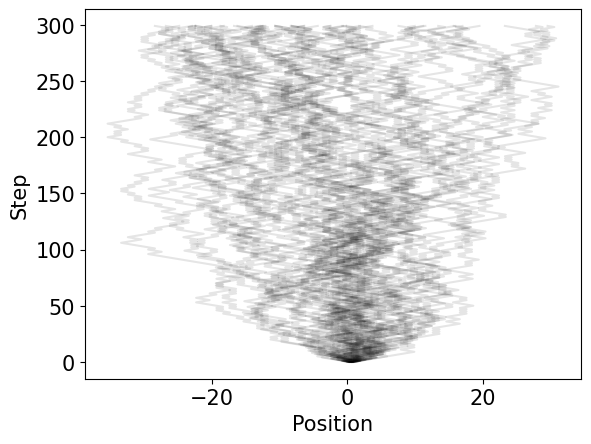

In [3]:
# Crate 50 particles, each runs 300 steps
N=300
n_particles = 50

trajectories = np.array([Gen_Randwalk(N) for i in range(n_particles)])

# You need this `walks` container and do update on this when you
# create the animation.
for traj in trajectories:
    plt.plot(traj,range(N), 'k', alpha=.1)

plt.xlabel('Position')
plt.ylabel('Step');

## Distribution of positions

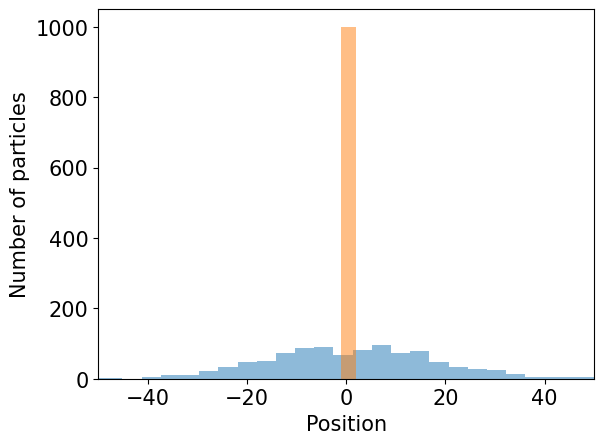

In [4]:
# Show how position distribution changes in time
# Crate 50 particles, each runs 300 steps
N=300
n_particles = 1000 # many more particles for better statistics

trajectories = np.array([Gen_Randwalk(N) for i in range(n_particles)])



fig2,ax = plt.subplots()

def init():
    ax.set_xlim(-50,50)
    plt.hist(trajectories[:,1] ,bins=1, alpha=.5)

    plt.xlabel('Position')
    plt.ylabel('Number of particles')



def update(frame):
    plt.cla()
    plt.xlim(-50,50)
    plt.hist(trajectories[:,frame], bins=int(frame/10)+1, alpha=.5)

    plt.xlabel('Position')
    plt.ylabel('Number of particles')



ani = animation.FuncAnimation(fig2,update,frames=range(N),init_func=init)
HTML(ani.to_jshtml())

## Normality of the distribution

We know from theory that the probability of finding a particle in position $x$ after $n$ random walk steps is distributed as a gaussian with mean $\mu(t) = 0$ and standard deviation $\sigma(t) = \delta \sqrt t$.

We can plot this prediction alongside the simulated data and check that this is indeed the case! Note also that the second plot shows that the variance in the experiments scales exactly as predicted by the theory.

In [5]:
# theoretical standard deviation after n steps
def rw_std(n, delta=1):
    return delta * np.sqrt(n)

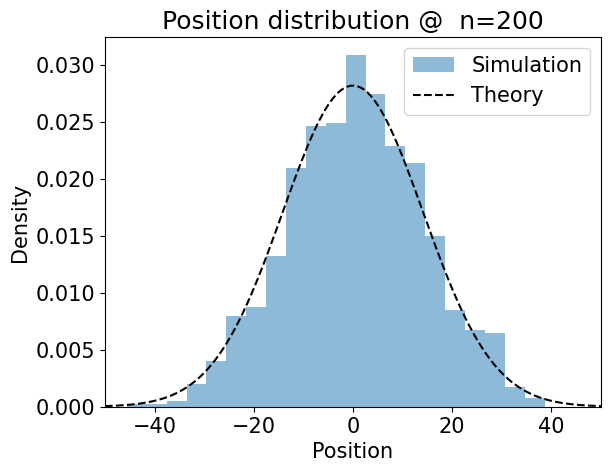

In [6]:
n=200

plt.hist(trajectories[:,n], bins=int(n/10)+1, density=True, alpha=.5, label='Simulation')

x = np.linspace(-50,50,1000)
y = scipy.stats.norm.pdf(x, loc=0, scale=rw_std(n))
plt.plot(x, y, 'k--', label='Theory')

plt.xlim(-50,50)
plt.xlabel('Position')
plt.ylabel('Density')

plt.title('Position distribution @  n=%d' % n)

plt.legend();

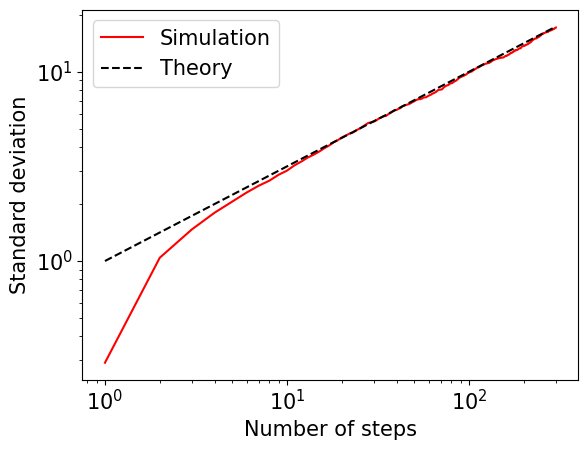

In [7]:
steps=np.arange(1, N)

# Calculate width of distribution
data_std = np.std(trajectories, axis=0)

plt.plot(np.arange(1, N+1), data_std, 'r', label='Simulation')
plt.plot(steps, rw_std(steps), 'k--', label='Theory')

plt.xlabel('Number of steps')
plt.ylabel('Standard deviation')

plt.xscale('log')
plt.yscale('log')

plt.legend();

# Stock Prices and Random Walk

A very common assumption in financial models is that stock prices follow some version of a random walk. Let's analyze S&P 500 prices as an example.

## Load S&P 500 historical prices

In [8]:
import pandas as pd
import yfinance as yf

import scipy

In [9]:
# Download S&P 500 data
sp500 = yf.download('^GSPC', start='1950-01-01', end='2024-09-15', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [10]:
sp500.tail()

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2024-09-09  5471.049805  5484.200195  5434.490234  5442.069824  3825940000
2024-09-10  5495.520020  5497.910156  5441.720215  5490.509766  3848180000
2024-09-11  5554.129883  5560.410156  5406.959961  5496.419922  3839450000
2024-09-12  5595.759766  5600.709961  5535.500000  5557.479980  3655070000
2024-09-13  5626.020020  5636.270020  5601.649902  5603.339844  3500790000

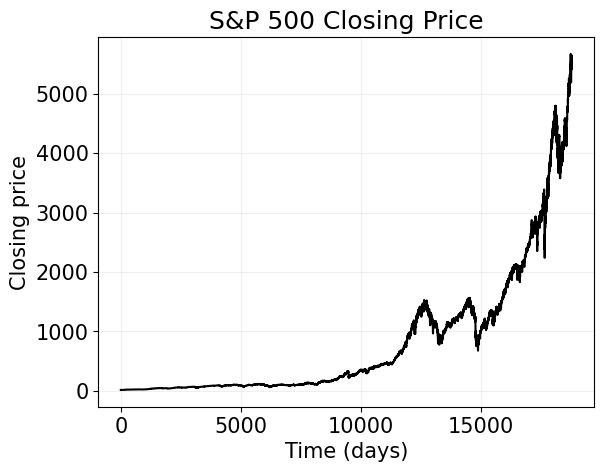

In [11]:
# Plot closing price versus time
plt.plot(np.arange(1, len(sp500) + 1), sp500['Close'], 'k')

plt.xlabel('Time (days)')
plt.ylabel('Closing price')
plt.title('S&P 500 Closing Price')

plt.grid(alpha=.2)

plt.show()


The distribution of prices look much more like a power law than a log-normal distribution:

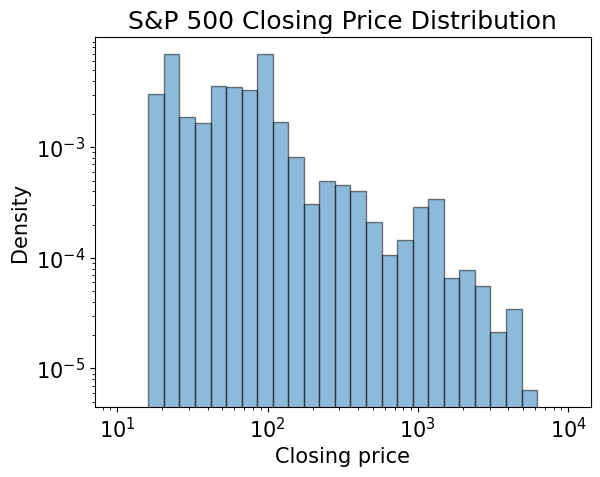

In [12]:
plt.hist(sp500['Close'], bins=np.logspace(1,4,30), density=True, alpha=.5, edgecolor='k')

plt.xscale('log')
plt.yscale('log')


plt.xlabel('Closing price')
plt.ylabel('Density')
plt.title('S&P 500 Closing Price Distribution');


## Returns and log-returns

Given a stock with price $p(t)$, the return at time $t$ is defined as:

$$
r(t) = \frac{p(t) - p(t-1)}{p(t-1)}
$$

This gives the percentage change in the stock price from one day to the next. If the price follows a random walk, then the return should be distributed as a Gaussian.

Very often one is interested in the log-return, defined as:

$$
R(t) = \log\left(\frac{p(t)}{p(t-1)}\right)
$$

The log-return is the logarithm of the return, and is often used in finance because it is additive over time. It also has the nice property that the log-return of a product whose price is distributed as a log-normal distribution (a very common base hypothesis) is normally distributed.

In [13]:
# Calculate log returns
returns = sp500['Close'].pct_change()[1:]
### Equivalent to:
# returns = (sp500['Close'] / sp500['Close'].shift(1) - 1).dropna()

## Calculate log returns
log_returns = np.log(1+returns)

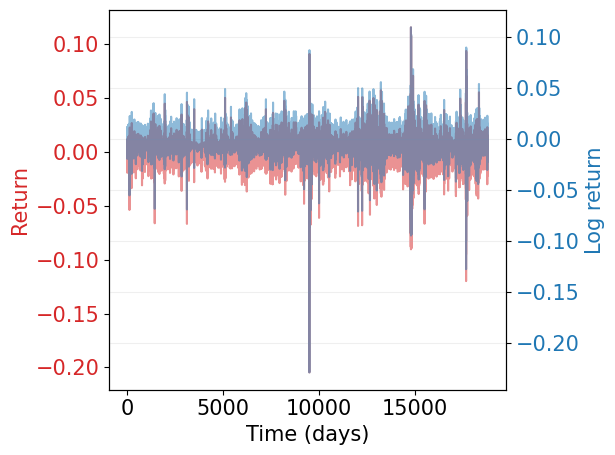

In [14]:
#plot returns and log returns vs time on the same line
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Return', color=color)
ax1.plot(np.arange(1, len(returns) + 1), returns, color=color, alpha=.5)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Log return', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(1, len(log_returns) + 1), log_returns, color=color, alpha=.5)
ax2.tick_params(axis='y', labelcolor=color)

plt.grid(alpha=.2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Return distribution

The distribution of the returns looks more like a fat-tailed distribution than a Gaussian (this affirmation is purely qualitative and should be appropriately quantified before deriving any conclusion).

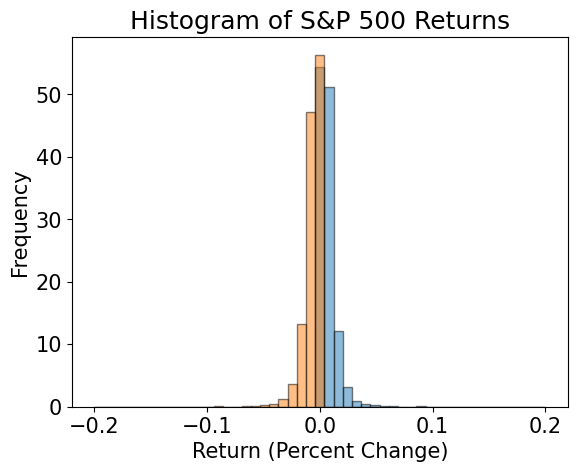

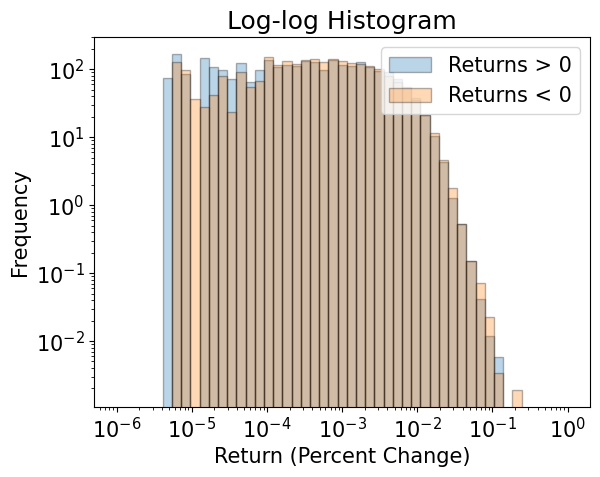

In [15]:
bins = np.linspace(-.2, .2, 50)

plt.hist(returns[returns>0], bins=bins, density=True, alpha=.5, label='Returns', edgecolor='k')
plt.hist(returns[returns<0], bins=bins, density=True, alpha=.5, label='Returns', edgecolor='k')


plt.xlabel('Return (Percent Change)')
plt.ylabel('Frequency')
plt.title('Histogram of S&P 500 Returns')
plt.show()


logbins = np.logspace(-6,0,50)
plt.hist(returns[returns>0], bins=logbins, density=True, alpha=.3, label='Returns > 0', edgecolor='k')
plt.hist(-returns[returns<0], bins=logbins, density=True, alpha=.3, label='Returns < 0', edgecolor='k')


plt.xscale('log')
plt.yscale('log')

plt.xlabel('Return (Percent Change)')
plt.ylabel('Frequency')
plt.title('Log-log Histogram')

plt.legend()
plt.show()


### Log-return distribution

Also in this case the distribution of the returns looks more like a fat-tailed distribution than a Gaussian. This should be expected since for very small values of returns $r_t$ we have $\log(1+r_t) \approx r_t$.

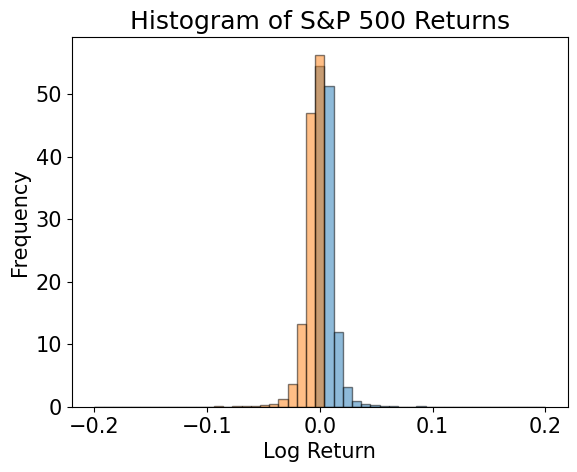

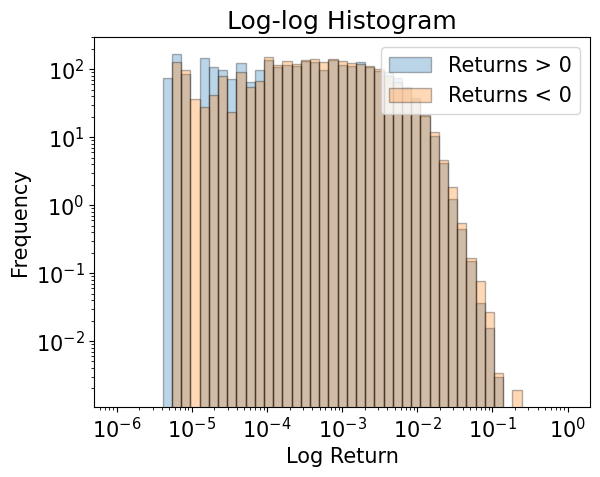

In [16]:
bins = np.linspace(-.2, .2, 50)

plt.hist(log_returns[log_returns>0], bins=bins, density=True, alpha=.5, label='Returns', edgecolor='k')
plt.hist(log_returns[log_returns<0], bins=bins, density=True, alpha=.5, label='Returns', edgecolor='k')


plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.title('Histogram of S&P 500 Returns')
plt.show()


logbins = np.logspace(-6,0,50)
plt.hist(log_returns[log_returns>0], bins=logbins, density=True, alpha=.3, label='Returns > 0', edgecolor='k')
plt.hist(-log_returns[log_returns<0], bins=logbins, density=True, alpha=.3, label='Returns < 0', edgecolor='k')


plt.xscale('log')
plt.yscale('log')

plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.title('Log-log Histogram')

plt.legend()
plt.show()


**In the case of the S&P 500 the random walk hypothesis doesn't seem to hold very well!**